# Accelerated Failure Time

* The canonical example of Accelerated Failure Time models, shared by Kleinbaum & Klein in Survival Analysis: A Self-Learning Text, is the lifespan of dogs. It is commonly accepted that dogs age 7x faster than humans. They go through the same lifestages that we do, just faster.

* In contrast to Kaplan-Meier and Cox Proportional Hazards, Accelerated Failure Time is a parametric model. This means that the outcome variable is assumed to follow a specified distribution. Parametric models are typically less 'flexible' than non-parametric and semi-parametric models but can be a good choice when you're comfortable with specifying the distribution of the outcome variable.

* Similar to Cox Proportional Hazards, the Accelerated Failure Time model has underlying assumptions to be aware of. These assumptions are covered below.

## The Accelerated Failure Time Model Equation

* Using the Accelerated Failure Time equation below, if we were to define group A as humans and group B as dogs, then the acceleration factor would be 7. Similarly, if we define group A as dogs and group B as humans, then the acceleration factor would be 1/7.

* The specification for lambda, which represents the accelerated failure rate, is intentionally generalized here. In practice, the survival function for the accelerated failure rate includes one or more parameters. For example, the specification when using log-logistic accelerated failure time is: 1/(1+lambda x t ^ p).

* The full specification of the accelerated failure rate is most relevant when using log-log plots to verify whether the accelerated failure time assumptions have been violated. This is covered in further detail below.

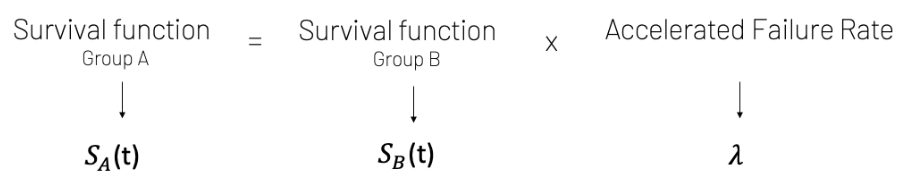

#### Setup

In [ ]:
! pip install lifelines

In [2]:
# Import libraries
import pandas as pd
import seaborn as sns
import numpy as np

from lifelines.fitters.coxph_fitter import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from lifelines import KaplanMeierFitter

In [ ]:
! wget https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv

In [4]:
df = pd.read_csv('/content/Telco-Customer-Churn.csv')

# To keep the analysis focused, let's just filter to internet subscribers with a month-to-month contract
df = df[df['Contract'] == 'Month-to-month']

df = df[df['InternetService'] != 'No']

# Convert Churn column to a boolean
df['Churn'] = df['Churn'].replace(to_replace=['No', 'Yes'], value=[0, 1])

print('Data Shape : ', df.shape)
df.head()

Data Shape :  (3351, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,0


### One-Hot Encode the Categorical Variables

* As is the case when using the Lifelines library to fit a Cox Proportional Hazards model, you must one-hot encode your categorical columns when using an Accelerated Failure Time model. We have hand-selected 8 variables to use for this notebook.

* After one-hot encoding the variables, we then created a new dataframe consisting of only the columns we need in order to fit the model.

* When creating the dataframe that you will use to fit the model, it is important that you drop one column for each one-hot encoded variable. For example, we included dependents_yes and dropped dependents_no. If you neglect to do this, you will likely receive an error when fitting the model that states that there are multi-collinearity issues with your data. This means that certain columns are highly correlated. For example, if you know that dependents_yes = 1 then you in turn know that dependents_no = 0.

* You can take one of two approaches when dropping variables. When using Pandas' get_dummies() function, you can simply set drop_first = True. An alternative approach, which is the one taken here, is to hand-select which variables to drop. In this notebook, we dropped the value that had a Kaplan-Meier survival probability curve most similar to the population. While this is by no means necessary, it affords an intuitive interpretation as the baseline closely resembles the population.

In [5]:
encode_cols = ['Partner','MultipleLines','InternetService','OnlineSecurity', 'OnlineBackup','DeviceProtection','TechSupport','PaymentMethod']
 
encoded_pd = pd.get_dummies(df,
               columns=encode_cols,
               prefix=encode_cols,
               drop_first=False)
 
encoded_pd.head()

,customerID,gender,SeniorCitizen,Dependents,tenure,PhoneService,StreamingTV,StreamingMovies,Contract,PaperlessBilling,...,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,Female,0,No,1,No,No,No,Month-to-month,Yes,...,0,1,1,0,1,0,0,0,1,0
2,3668-QPYBK,Male,0,No,2,Yes,No,No,Month-to-month,Yes,...,0,1,1,0,1,0,0,0,0,1
4,9237-HQITU,Female,0,No,2,Yes,No,No,Month-to-month,Yes,...,1,0,1,0,1,0,0,0,1,0
5,9305-CDSKC,Female,0,No,8,Yes,Yes,Yes,Month-to-month,Yes,...,1,0,0,1,1,0,0,0,1,0
6,1452-KIOVK,Male,0,Yes,22,Yes,Yes,No,Month-to-month,Yes,...,0,1,1,0,1,0,0,1,0,0


In [7]:
survival_pd = encoded_pd[['Churn','tenure','Partner_Yes', 'MultipleLines_Yes', \
                          'InternetService_DSL','OnlineSecurity_Yes','OnlineBackup_Yes','DeviceProtection_Yes','TechSupport_Yes',\
                          'PaymentMethod_Bank transfer (automatic)','PaymentMethod_Credit card (automatic)']]